<a href="https://colab.research.google.com/github/hkbu-kennycheng/comp3925/blob/main/lab7_interactive_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# lab7 interactive visualization

Mounting Google Drive in Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!apt update
!apt install chromium-browser chromium-chromedriver fonts-noto fonts-noto-cjk
!pip install pyppeteer nest_asyncio pandas numpy tqdm seaborn requests
# for local runtime with anaconda, please comment out above code and use following conda install intead
# !pip install pyppeteer nest_asyncio pandas numpy tqdm seaborn

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa

In [14]:
import asyncio
import nest_asyncio
from pyppeteer import launch
import pandas as pd
import numpy as np

nest_asyncio.apply()

In [4]:
def runAndReturn(func):
  return asyncio.get_event_loop().run_until_complete(asyncio.gather(func))[0]

# Data collection and processing

## HKTVMall

In [10]:
from time import time, sleep
import requests

def getLeafCategories():
  response = requests.get(f'https://apps.hktvmall.com/cate_map/eese/cate_code_convert.json?_={time()*1000}')
  rawdata = response.json()
  return [m['hktvmall_original_code'] for m in rawdata['cate_codes_map'] if not m['hktvmall_original_code'][-3:] == '000']


In [11]:
async def getCategoryTotalPages(catid):
  browser = await launch({'executablePath':'/usr/bin/chromium-browser', 'headless': True, 'args':['--no-sandbox']})
  # browser = await launch({'headless' :False})
  page = await browser.newPage() # open a new browser window
  await page.setUserAgent('Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36')
  await page.setViewport({'width':1280, 'height':1024})
  await page.goto(f'https://www.hktvmall.com/hktv/en/search_a?category={catid}', { 'waitUntil':'networkidle0' })
  totalText = await page.Jeval('.paginationMenu-content span', 'node => node.textContent')
  await browser.close()
  return totalText.lstrip('/').rstrip('Pages').strip()

In [12]:
async def gethktvmall(catid):
  data = []
  total = int(await getCategoryTotalPages(catid))
  browser = await launch({'executablePath':'/usr/bin/chromium-browser', 'headless': True, 'args':['--no-sandbox']})
  # browser = await launch({'headless' :False})
  page = await browser.newPage() # open a new browser window
  await page.setUserAgent('Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36')
  await page.setViewport({'width':1280, 'height':1024})
  for i in range(total):
    await page.goto(f'https://www.hktvmall.com/hktv/en/search_a?category={catid}&page={i}', { 'waitUntil':'networkidle0' })
    data += [{
      'name': ''.join(await e.JJeval('.brand-product-name','nodes => Array.from(nodes).map(node => node.textContent)')),
      'packing': ''.join(await e.JJeval('.packing-spec','nodes => Array.from(nodes).map(node => node.textContent)')),
      'sales': ''.join(await e.JJeval('.salesNumber-container','nodes => Array.from(nodes).map(node => node.textContent)')),
      'reviews': ''.join(await e.JJeval('.review-number','nodes => Array.from(nodes).map(node => node.textContent)')),
      'price': ''.join(await e.JJeval('.price','nodes => Array.from(nodes).map(node => node.textContent)')),
      'store_name': ''.join(await e.JJeval('.store-name-label','nodes => Array.from(nodes).map(node => node.textContent)')),
    } for e in await page.JJ('.product-brief-wrapper')]
  await browser.close()
  return pd.DataFrame(data)

In [ ]:
runAndReturn(gethktvmall('AA11031000001'))

,name,packing,sales,reviews,price,store_name
0,Gourmet Market HK - DANISH NATURE PORK COLLAR ...,,"50,000+ Sold",(854),$ 63.80,Gourmet Market HK
1,Food Daily - POLAND NATURAL MID JOINT CHICKEN ...,,"6,000+ Sold",(29),$ 55.00,Food Daily
2,Kam Yu Fung - Malaysian White Fishball #chewy#...,Est. 270-300g,"5,000+ Sold",(42),$ 39.00,Food god
3,CoolFood - Minji Angus Beef,400g,"20,000+ Sold",(261),$ 39.90,CoolFood
4,Gourmet Market HK - PREMIUM NEW ZEALAND ANGUS ...,,"2,000+ Sold",(25),$ 69.80,Gourmet Market HK
...,...,...,...,...,...,...
419,Food Daily - VANILLA PUFF 6PCS 360G (FROZEN),,,,$ 63.50,Food Daily
420,Food Daily - $99 COMBO SET A (FROZEN),,,,$ 99.00,Food Daily
421,Batata Greens - 2Packs - Vegan Algae Chinese P...,,,,$ 108.00,Happy Moment 丨開心生活-專門店
422,Batata Greens - 2Packs - Vegan Algae Chinese P...,,,,$ 108.00,JK Organic 有機店｜天然健康食品用品生活專門店


### Data collection

In [ ]:
from tqdm import tqdm
from os.path import exists

df = pd.DataFrame()

for id in tqdm(getLeafCategories()):
  if exists(f'/content/drive/MyDrive/{id}.csv'):
    continue
  catdf = runAndReturn(gethktvmall(id))
  catdf.to_csv(f'/content/drive/MyDrive/{id}.csv')
  df = df.append(catdf)

#### Loading dataset from drive

In [18]:
import glob

hktvmalldf = pd.DataFrame()

for f in glob.glob('/content/drive/MyDrive/AA*.csv'):
  hktvmalldf = hktvmalldf.append(pd.read_csv(f, index_col=0), ignore_index=True)

In [20]:
hktvmalldf.to_csv('/content/drive/MyDrive/hktvmall.csv')

#### Loading dataset from csv

In [63]:
!curl https://gist.githubusercontent.com/hkbu-kennycheng/2cfddd0279b52f6e14812b5cad32330c/raw/28a2b55766a897a1755ef60030f3aa37bec44a33/hktvmall.csv > hktvmall.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16.6M  100 16.6M    0     0  24.1M      0 --:--:-- --:--:-- --:--:-- 24.1M


In [15]:
hktvmalldf = pd.read_csv('hktvmall.csv', index_col=0)
hktvmalldf

,name,packing,sales,reviews,price,store_name
0,Chupa Chups - Direct from France - CHUPA CHUPS...,NaN,200+ Sold,(2),$ 41.00,LAZUR GOURMET
1,L'Azur Gourmet - PAYSANS D'ICI - Organic Apple...,NaN,60+ Sold,NaN,$ 79.00,LAZUR GOURMET
2,L'Azur Gourmet - CLUB DES SOMMELIERS - Banyuls...,NaN,10+ Sold,NaN,$ 133.00,LAZUR GOURMET
3,Cradle Fresh - CLUB DES SOMMELIERS - Maury Ros...,NaN,NaN,NaN,$ 136.00,LAZUR GOURMET
4,Grace Cup - D197 Musang King Frozen Durian Pul...,200 g,100+ Sold,(3),$ 198.00,Mandarin Kitchen
...,...,...,...,...,...,...
146268,Sunstar - SOFT PICK 40P S~LL,NaN,NaN,NaN,$ 35.00,JDH Mall
146269,GUM - Soft-Picks Original Dental Picks Paralle...,50 count,NaN,NaN,$ 68.00,FRESHCO Mart
146270,Micro Sun - Toothbat dental floss (prevent per...,NaN,10+ Sold,NaN,$ 258.00,Micro Sun Project Limited
146271,3M - 3M Dental Floss Picks Disposable flosser ...,NaN,200+ Sold,(2),$ 48.00,Hometastic 生活百貨


### Data cleaning

In [16]:
hktvmalldf['name'] = hktvmalldf['name'].str.strip()
hktvmalldf['packing'] = hktvmalldf['packing'].str.strip()
hktvmalldf['sales'] = hktvmalldf['sales'].str.strip().str.rstrip(' Sold').str.rstrip('+').str.replace(',','').astype(float)
hktvmalldf['reviews'] = hktvmalldf['reviews'].str.strip().str.lstrip('(').str.rstrip(')').astype(float)
hktvmalldf['price'] = hktvmalldf['price'].str.strip().str.lstrip('$ ').str.replace(',','').replace('Not For Sale', np.nan).astype(float)
hktvmalldf['store_name'] = hktvmalldf['store_name'].str.strip()

In [17]:
hktvmalldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146273 entries, 0 to 146272
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   name        146245 non-null  object 
 1   packing     66707 non-null   object 
 2   sales       94856 non-null   float64
 3   reviews     56915 non-null   float64
 4   price       146270 non-null  float64
 5   store_name  146245 non-null  object 
dtypes: float64(3), object(3)
memory usage: 7.8+ MB


#### Check for duplicate data

In [ ]:
hktvmalldf[hktvmalldf.duplicated(['name', 'packing', 'price', 'store_name'],keep=False)]

## ParkNShop

### Data collection

In [65]:
from time import sleep
import urllib.parse

async def getPnKWithKeyword(keyword):
  data = []
  perPage = 100
  url = f'https://www.parknshop.com/en/search?code=ALL&text={keyword}&searchField={keyword}&resultsForPage={perPage}'
  browser = await launch({'executablePath':'/usr/bin/chromium-browser', 'headless': True, 'args':['--no-sandbox']}) # For Google Colab
  #browser = await launch({'headless':False}) # For loacl runtime
  page = await browser.newPage() # open a new browser window
  await page.setUserAgent('Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36')
  await page.setViewport({'width':1280, 'height':1024})
  await page.goto(f'https://queue.parknshop.com.hk/?c=aswatson&e=pnsprdhk&t={urllib.parse.quote_plus(url)}',{'waitUntil':'networkidle0'})
  await page.screenshot({'path':'PnKqueue.png', 'fullPage':True})
  await page.waitForSelector('#MainPart_divProgressbar_Progress_Runner', {'timeout':0, 'hidden':True})
  await page.waitForSelector('.showMore', {'timeout':60000, 'visible':True})
  await page.screenshot({'path':'PnKsearch.png', 'fullPage':True})

  total = int(await page.Jeval('[data-product_list_total_items]','node => node.getAttribute("data-product_list_total_items")'))
  i = 1
  while True:
    print(f'loop {keyword} show more {i}/{total//perPage}')
    showMore = await page.waitForSelector('.showMore', {'visible':True})
    await showMore.focus()
    await page.Jeval('.showMore a','node => node.click()')
    await page.waitForSelector('.isloading-overlay', {'timeout':0,'hidden':True})
    # sleep(1)
    showMore = await page.J('.showMore')
    if showMore == None or await showMore.boxModel() == None:
      break
    await showMore.screenshot({'path':'showmore.png'})
    i += 1
    if i > 40:
      break
  await page.screenshot({'path':f'{keyword}.png','fullPage':True})
  for p in await page.JJ('.product-container > .item'):
    # print('loop products')
    await p.hover()
    await p.focus()
    data.append({
      'name':await p.Jeval('.homeProductCarousel', 'node => node.getAttribute("data-gtm-homeproductcarousel-name")'),
      'id':''.join(await p.JJeval('.homeProductCarousel', 'nodes => nodes.map(node => node.getAttribute("data-gtm-homeproductcarousel-id"))')),
      'url':'https://www.parknshop.com'+await p.Jeval('.pic > a', 'node => node.getAttribute("data-link")'),
      'pic':'https://www.parknshop.com'+await p.Jeval('.pic > a > img', 'node => node.getAttribute("data-original")'),
      'price':await p.Jeval('.homeProductCarousel', 'node => node.getAttribute("data-gtm-homeproductcarousel-price")'),
      'specialoffer':''.join(await p.JJeval('.special-offer', 'nodes => nodes.map(node => node.textContent)')),
      'brand':await p.Jeval('.homeProductCarousel', 'node => node.getAttribute("data-gtm-homeproductcarousel-brand")'),
      'category':await p.Jeval('.homeProductCarousel', 'node => node.getAttribute("data-gtm-homeproductcarousel-category")'),
      'variant':await p.Jeval('.homeProductCarousel', 'node => node.getAttribute("data-gtm-homeproductcarousel-variant")'),
      'variantname':await p.Jeval('.homeProductCarousel', 'node => node.getAttribute("data-gtm-homeproductcarousel-variant_name")'),
      'topseller':len(await p.JJ('.topSeller')) == 1,
      'fairtrade':len(await p.JJ('.fairTrade')) == 1,
      'organic':len(await p.JJ('.organic')) == 1,
      'eshoponly':len(await p.JJ('.eShopOnly')) == 1,
      'healthyfat':len(await p.JJ('.healthyFat')) == 1,
      'crustacean':len(await p.JJ('.crustacean')) == 1,
    })
  await browser.close()
  return data

In [66]:
%%time
coffeedf = pd.DataFrame(runAndReturn(getPnKWithKeyword('coffee')))

#### Loading data from csv

In [40]:
!curl https://gist.githubusercontent.com/hkbu-kennycheng/b95757c385ac5e49a1abb1434a966f6c/raw/5110cce1df181d67411c949c304655572740d0b9/pnk.csv > pnk.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4228k  100 4228k    0     0  6349k      0 --:--:-- --:--:-- --:--:-- 6349k


In [41]:
import pandas as pd

pnkdf = pd.read_csv('pnk.csv', index_col=0)
pnkdf

,name,id,url,pic,price,specialoffer,brand,category,variant,variantname,...,organic,eshoponly,healthyfat,crustacean,Product Details,Origin,Product Warnings,Product Usage,Storage Condition,Ingredients
0,Alkaline Water 9.0 (random Pick),499585,https://www.parknshop.com/en/alkaline-water-9-...,https://www.parknshop.com/medias/sys_master/fr...,9.0,NaN,WATSONS,Water,499585,420ML,...,False,False,False,False,- Smart way to hydrate your body- Helps to neu...,Hong Kong,This product contains minerals and is electrol...,Consume shortly after opening.,Keep in a cool dry place away from direct sunl...,"Water, Ocean Mineral Concentrate"
1,Alkaline Water 9.0 (case) (420ml X 24 Bottles),378829,https://www.parknshop.com/en/alkaline-water-9-...,https://www.parknshop.com/medias/sys_master/fr...,168.0,NaN,WATSONS,"Water,Bottled Water",378829,24X420ML,...,False,False,False,False,- Helps neutralize acidity-Help the body detox...,Hong Kong,Keep in a cool dry place away from direct sunl...,drink,Keep in a cool dry place away from direct sunl...,"Water, Ocean Mineral Concentrate"
2,L Type Interdental Brush 0.6mm - 6pcs,805629,https://www.parknshop.com/en/l-type-interdenta...,https://www.parknshop.com/medias/sys_master/fr...,13.9,$20.8 / 2pcs,WATSONS,Dental Accessories & Denture,805629,6S,...,False,False,False,False,WATSONS ORAL CARE RANGE IS SPECIALLY DESIGNED ...,China,Do not force the interdental brush between tee...,1. PUT THE INTERDENTAL BRUSH BETWEEN THE TEETH...,"STORE IN A COOL, DRY PLACE AWAY FROM DIRECT SU...",NaN
3,L Type Interdental Brush 0.8mm 6pcs,805630,https://www.parknshop.com/en/l-type-interdenta...,https://www.parknshop.com/medias/sys_master/fr...,13.9,$20.8 / 2pcs,WATSONS,Dental Accessories & Denture,805630,6S,...,False,False,False,False,WATSONS ORAL CARE RANGE IS SPECIALLY DESIGNED ...,China,Do not force the interdental brush between tee...,1. PUT THE INTERDENTAL BRUSH BETWEEN THE TEETH...,"STORE IN A COOL, DRY PLACE AWAY FROM DIRECT SU...",NaN
4,I Type Interdental Brush 0.7mm 5pcs,805627,https://www.parknshop.com/en/i-type-interdenta...,https://www.parknshop.com/medias/sys_master/fr...,10.0,$15.0 / 2pcs,WATSONS,Dental Accessories & Denture,805627,5S,...,False,False,False,False,WATSONS ORAL CARE RANGE IS SPECIALLY DESIGNED ...,China,Do not force the interdental brush between tee...,1. PUT THE INTERDENTAL BRUSH BETWEEN THE TEETH...,"STORE IN A COOL, DRY PLACE AWAY FROM DIRECT SU...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6722,Kitchen Towel 9inch,365593,https://www.parknshop.com/en/kitchen-towel-9in...,https://www.parknshop.com/medias/sys_master/fr...,25.9,MONEYBACK MEMBER OFFER,BEST BUY,NaN,365593,6S,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
6723,Chauzhou Style Fish Balls,51761,https://www.parknshop.com/en/chauzhou-style-fi...,https://www.parknshop.com/medias/sys_master/fr...,8.4,MONEYBACK MEMBER OFFER,JIU LONG CHENG ZHAI,Seafood Balls,51761,170G/PKT,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
6724,Alkaline Ion Water,483353,https://www.parknshop.com/en/alkaline-ion-wate...,https://www.parknshop.com/medias/sys_master/fr...,19.9,MONEYBACK MEMBER OFFER,KIRIN,Water,483353,2L,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
6725,Mushroom Pork Ball,55251,https://www.parknshop.com/en/mushroom-pork-bal...,https://www.parknshop.com/medias/sys_master/fr...,13.9,MONEYBACK MEMBER OFFER,JIU LONG CHENG ZHAI,Meat Balls,55251,170G,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN


### Data cleaning

Cleaning empty space characters with strip for object columns

In [42]:
pnkdf['name'] = pnkdf['name'].str.strip()
pnkdf['url'] = pnkdf['url'].str.strip()
pnkdf['pic'] = pnkdf['pic'].str.strip()
pnkdf['specialoffer'] = pnkdf['specialoffer'].str.strip()
pnkdf['brand'] = pnkdf['brand'].str.strip()
pnkdf['category'] = pnkdf['category'].str.strip()
pnkdf['variantname'] = pnkdf['variantname'].str.strip()

pnkdf

,name,id,url,pic,price,specialoffer,brand,category,variant,variantname,...,organic,eshoponly,healthyfat,crustacean,Product Details,Origin,Product Warnings,Product Usage,Storage Condition,Ingredients
0,Alkaline Water 9.0 (random Pick),499585,https://www.parknshop.com/en/alkaline-water-9-...,https://www.parknshop.com/medias/sys_master/fr...,9.0,NaN,WATSONS,Water,499585,420ML,...,False,False,False,False,- Smart way to hydrate your body- Helps to neu...,Hong Kong,This product contains minerals and is electrol...,Consume shortly after opening.,Keep in a cool dry place away from direct sunl...,"Water, Ocean Mineral Concentrate"
1,Alkaline Water 9.0 (case) (420ml X 24 Bottles),378829,https://www.parknshop.com/en/alkaline-water-9-...,https://www.parknshop.com/medias/sys_master/fr...,168.0,NaN,WATSONS,"Water,Bottled Water",378829,24X420ML,...,False,False,False,False,- Helps neutralize acidity-Help the body detox...,Hong Kong,Keep in a cool dry place away from direct sunl...,drink,Keep in a cool dry place away from direct sunl...,"Water, Ocean Mineral Concentrate"
2,L Type Interdental Brush 0.6mm - 6pcs,805629,https://www.parknshop.com/en/l-type-interdenta...,https://www.parknshop.com/medias/sys_master/fr...,13.9,$20.8 / 2pcs,WATSONS,Dental Accessories & Denture,805629,6S,...,False,False,False,False,WATSONS ORAL CARE RANGE IS SPECIALLY DESIGNED ...,China,Do not force the interdental brush between tee...,1. PUT THE INTERDENTAL BRUSH BETWEEN THE TEETH...,"STORE IN A COOL, DRY PLACE AWAY FROM DIRECT SU...",NaN
3,L Type Interdental Brush 0.8mm 6pcs,805630,https://www.parknshop.com/en/l-type-interdenta...,https://www.parknshop.com/medias/sys_master/fr...,13.9,$20.8 / 2pcs,WATSONS,Dental Accessories & Denture,805630,6S,...,False,False,False,False,WATSONS ORAL CARE RANGE IS SPECIALLY DESIGNED ...,China,Do not force the interdental brush between tee...,1. PUT THE INTERDENTAL BRUSH BETWEEN THE TEETH...,"STORE IN A COOL, DRY PLACE AWAY FROM DIRECT SU...",NaN
4,I Type Interdental Brush 0.7mm 5pcs,805627,https://www.parknshop.com/en/i-type-interdenta...,https://www.parknshop.com/medias/sys_master/fr...,10.0,$15.0 / 2pcs,WATSONS,Dental Accessories & Denture,805627,5S,...,False,False,False,False,WATSONS ORAL CARE RANGE IS SPECIALLY DESIGNED ...,China,Do not force the interdental brush between tee...,1. PUT THE INTERDENTAL BRUSH BETWEEN THE TEETH...,"STORE IN A COOL, DRY PLACE AWAY FROM DIRECT SU...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6722,Kitchen Towel 9inch,365593,https://www.parknshop.com/en/kitchen-towel-9in...,https://www.parknshop.com/medias/sys_master/fr...,25.9,MONEYBACK MEMBER OFFER,BEST BUY,NaN,365593,6S,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
6723,Chauzhou Style Fish Balls,51761,https://www.parknshop.com/en/chauzhou-style-fi...,https://www.parknshop.com/medias/sys_master/fr...,8.4,MONEYBACK MEMBER OFFER,JIU LONG CHENG ZHAI,Seafood Balls,51761,170G/PKT,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
6724,Alkaline Ion Water,483353,https://www.parknshop.com/en/alkaline-ion-wate...,https://www.parknshop.com/medias/sys_master/fr...,19.9,MONEYBACK MEMBER OFFER,KIRIN,Water,483353,2L,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
6725,Mushroom Pork Ball,55251,https://www.parknshop.com/en/mushroom-pork-bal...,https://www.parknshop.com/medias/sys_master/fr...,13.9,MONEYBACK MEMBER OFFER,JIU LONG CHENG ZHAI,Meat Balls,55251,170G,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN


### Drop duplicates with id

In [43]:
len(pnkdf['id'].unique())

6727

In [44]:
pnkdf.drop_duplicates('id' ,inplace=True)

In [45]:
pnkdf

,name,id,url,pic,price,specialoffer,brand,category,variant,variantname,...,organic,eshoponly,healthyfat,crustacean,Product Details,Origin,Product Warnings,Product Usage,Storage Condition,Ingredients
0,Alkaline Water 9.0 (random Pick),499585,https://www.parknshop.com/en/alkaline-water-9-...,https://www.parknshop.com/medias/sys_master/fr...,9.0,NaN,WATSONS,Water,499585,420ML,...,False,False,False,False,- Smart way to hydrate your body- Helps to neu...,Hong Kong,This product contains minerals and is electrol...,Consume shortly after opening.,Keep in a cool dry place away from direct sunl...,"Water, Ocean Mineral Concentrate"
1,Alkaline Water 9.0 (case) (420ml X 24 Bottles),378829,https://www.parknshop.com/en/alkaline-water-9-...,https://www.parknshop.com/medias/sys_master/fr...,168.0,NaN,WATSONS,"Water,Bottled Water",378829,24X420ML,...,False,False,False,False,- Helps neutralize acidity-Help the body detox...,Hong Kong,Keep in a cool dry place away from direct sunl...,drink,Keep in a cool dry place away from direct sunl...,"Water, Ocean Mineral Concentrate"
2,L Type Interdental Brush 0.6mm - 6pcs,805629,https://www.parknshop.com/en/l-type-interdenta...,https://www.parknshop.com/medias/sys_master/fr...,13.9,$20.8 / 2pcs,WATSONS,Dental Accessories & Denture,805629,6S,...,False,False,False,False,WATSONS ORAL CARE RANGE IS SPECIALLY DESIGNED ...,China,Do not force the interdental brush between tee...,1. PUT THE INTERDENTAL BRUSH BETWEEN THE TEETH...,"STORE IN A COOL, DRY PLACE AWAY FROM DIRECT SU...",NaN
3,L Type Interdental Brush 0.8mm 6pcs,805630,https://www.parknshop.com/en/l-type-interdenta...,https://www.parknshop.com/medias/sys_master/fr...,13.9,$20.8 / 2pcs,WATSONS,Dental Accessories & Denture,805630,6S,...,False,False,False,False,WATSONS ORAL CARE RANGE IS SPECIALLY DESIGNED ...,China,Do not force the interdental brush between tee...,1. PUT THE INTERDENTAL BRUSH BETWEEN THE TEETH...,"STORE IN A COOL, DRY PLACE AWAY FROM DIRECT SU...",NaN
4,I Type Interdental Brush 0.7mm 5pcs,805627,https://www.parknshop.com/en/i-type-interdenta...,https://www.parknshop.com/medias/sys_master/fr...,10.0,$15.0 / 2pcs,WATSONS,Dental Accessories & Denture,805627,5S,...,False,False,False,False,WATSONS ORAL CARE RANGE IS SPECIALLY DESIGNED ...,China,Do not force the interdental brush between tee...,1. PUT THE INTERDENTAL BRUSH BETWEEN THE TEETH...,"STORE IN A COOL, DRY PLACE AWAY FROM DIRECT SU...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6722,Kitchen Towel 9inch,365593,https://www.parknshop.com/en/kitchen-towel-9in...,https://www.parknshop.com/medias/sys_master/fr...,25.9,MONEYBACK MEMBER OFFER,BEST BUY,NaN,365593,6S,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
6723,Chauzhou Style Fish Balls,51761,https://www.parknshop.com/en/chauzhou-style-fi...,https://www.parknshop.com/medias/sys_master/fr...,8.4,MONEYBACK MEMBER OFFER,JIU LONG CHENG ZHAI,Seafood Balls,51761,170G/PKT,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
6724,Alkaline Ion Water,483353,https://www.parknshop.com/en/alkaline-ion-wate...,https://www.parknshop.com/medias/sys_master/fr...,19.9,MONEYBACK MEMBER OFFER,KIRIN,Water,483353,2L,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
6725,Mushroom Pork Ball,55251,https://www.parknshop.com/en/mushroom-pork-bal...,https://www.parknshop.com/medias/sys_master/fr...,13.9,MONEYBACK MEMBER OFFER,JIU LONG CHENG ZHAI,Meat Balls,55251,170G,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN


### Grouping brand name

Check for dash in `pnkdf['brand']`

In [46]:
pnkdf[pnkdf['brand'].str.count('-') > 0]['brand'].describe()

count       0
unique      0
top       NaN
freq      NaN
Name: brand, dtype: object

replace dash with empty string in `pnkdf['brand']`

In [47]:
pnkdf['brand'] = pnkdf['brand'].str.replace('-','')
pnkdf['brand'].describe()

count       6624
unique      1467
top       SELECT
freq         263
Name: brand, dtype: object

In [56]:
pnkdf

,name,id,url,pic,price,specialoffer,brand,category,variant,variantname,topseller,fairtrade,organic,eshoponly,healthyfat,crustacean
0,Alkaline Water 9.0 (random Pick),499585,https://www.parknshop.com/en/alkaline-water-9-...,https://www.parknshop.com/medias/sys_master/fr...,9.0,NaN,WATSONS,Water,499585,420ML,False,False,False,False,False,False
1,Alkaline Water 9.0 (case) (420ml X 24 Bottles),378829,https://www.parknshop.com/en/alkaline-water-9-...,https://www.parknshop.com/medias/sys_master/fr...,168.0,NaN,WATSONS,"Water,Bottled Water",378829,24X420ML,False,False,False,False,False,False
2,L Type Interdental Brush 0.6mm - 6pcs,805629,https://www.parknshop.com/en/l-type-interdenta...,https://www.parknshop.com/medias/sys_master/fr...,13.9,$20.8 / 2pcs,WATSONS,Dental Accessories & Denture,805629,6S,False,False,False,False,False,False
3,L Type Interdental Brush 0.8mm 6pcs,805630,https://www.parknshop.com/en/l-type-interdenta...,https://www.parknshop.com/medias/sys_master/fr...,13.9,$20.8 / 2pcs,WATSONS,Dental Accessories & Denture,805630,6S,True,False,False,False,False,False
4,I Type Interdental Brush 0.7mm 5pcs,805627,https://www.parknshop.com/en/i-type-interdenta...,https://www.parknshop.com/medias/sys_master/fr...,10.0,$15.0 / 2pcs,WATSONS,Dental Accessories & Denture,805627,5S,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26909,Kitchen Towel 9inch,365593,https://www.parknshop.com/en/kitchen-towel-9in...,https://www.parknshop.com/medias/sys_master/fr...,25.9,MONEYBACK MEMBER OFFER,BEST BUY,NaN,365593,6S,True,False,False,False,False,False
27000,Chauzhou Style Fish Balls,51761,https://www.parknshop.com/en/chauzhou-style-fi...,https://www.parknshop.com/medias/sys_master/fr...,8.4,MONEYBACK MEMBER OFFER,JIU LONG CHENG ZHAI,Seafood Balls,51761,170G/PKT,True,False,False,False,False,False
27001,Alkaline Ion Water,483353,https://www.parknshop.com/en/alkaline-ion-wate...,https://www.parknshop.com/medias/sys_master/fr...,19.9,MONEYBACK MEMBER OFFER,KIRIN,Water,483353,2L,False,False,False,False,False,False
27002,Mushroom Pork Ball,55251,https://www.parknshop.com/en/mushroom-pork-bal...,https://www.parknshop.com/medias/sys_master/fr...,13.9,MONEYBACK MEMBER OFFER,JIU LONG CHENG ZHAI,Meat Balls,55251,170G,True,False,False,False,False,False


# Exploring data

## HKTVMall

In [31]:
hktvmalldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146273 entries, 0 to 146272
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   name        146245 non-null  object 
 1   packing     66707 non-null   object 
 2   sales       94856 non-null   float64
 3   reviews     56915 non-null   float64
 4   price       146270 non-null  float64
 5   store_name  146245 non-null  object 
dtypes: float64(3), object(3)
memory usage: 7.8+ MB


In [ ]:
len(hktvmalldf['store_name'].unique())

2604

### price

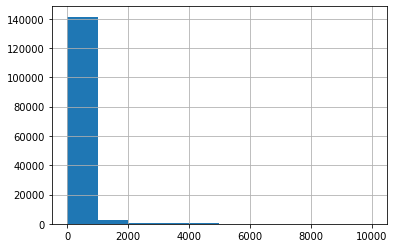

In [38]:
hktvmalldf[hktvmalldf['price'] < 10000]['price'].hist()

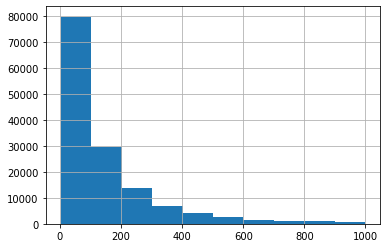

In [39]:
hktvmalldf[hktvmalldf['price'] < 1000]['price'].hist()

### store_name

In [147]:
hktvmalldf[['store_name','name']].groupby(by=['store_name']).count()

,name
store_name,
(OUR: ) Wellness Limited,26
(Opening Soon) Pinewood Store,27
-19° Degree,3
-On-Fire-火-,5
10 Acres,1894
...,...
里海 Caspi,464
集美生活,75
電器管家,12


In [152]:
hktvmalldf[['store_name','name']].groupby(by=['store_name']).count().sort_values(by=['name'], ascending=False)

,name
store_name,
大笪地,2889
貓犬工房,2217
10 Acres,1894
Beautique,1345
Duo Duo Store,1083
...,...
"HONG KONG TOP QUALITY GOODS CO., LIMITED",1
Sendo,1
MerryJAM,1


In [148]:
hktvmalldf[['store_name','price']].groupby(by=['store_name']).mean()

,price
store_name,
(OUR: ) Wellness Limited,198.996154
(Opening Soon) Pinewood Store,91.285185
-19° Degree,82.333333
-On-Fire-火-,261.200000
10 Acres,1717.493770
...,...
里海 Caspi,242.523491
集美生活,146.062667
電器管家,2317.666667


In [153]:
hktvmalldf[['store_name','price']].groupby(by=['store_name']).mean().sort_values(by=['price'], ascending=False)

,price
store_name,
HKTV Shop,9999.000000
JVG,9272.000000
Luxury Life Pavilion,9000.000000
Magic Living,8646.666667
A&M Shop,8260.000000
...,...
Mars Wrigley Flagship Store,17.000000
MAWI & CO. | The Lifestyle Store,15.000000
SUR RIVER FOOD,14.416667


## ParkNShop

In [48]:
pnkdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6727 entries, 0 to 6726
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               6720 non-null   object 
 1   id                 6727 non-null   int64  
 2   url                6727 non-null   object 
 3   pic                6727 non-null   object 
 4   price              6726 non-null   float64
 5   specialoffer       2527 non-null   object 
 6   brand              6624 non-null   object 
 7   category           6049 non-null   object 
 8   variant            6727 non-null   int64  
 9   variantname        6726 non-null   object 
 10  topseller          6727 non-null   bool   
 11  fairtrade          6727 non-null   bool   
 12  organic            6727 non-null   bool   
 13  eshoponly          6727 non-null   bool   
 14  healthyfat         6727 non-null   bool   
 15  crustacean         6727 non-null   bool   
 16  Product Details    5056 

### price

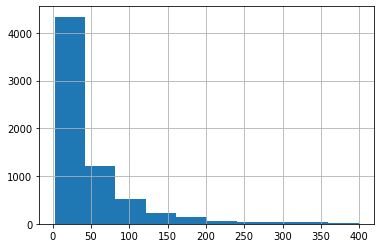

In [144]:
pnkdf[pnkdf['price'] < 400]['price'].hist()

### brand

In [53]:
len(pnkdf['brand'].unique())

1468

#### SELECT

In [107]:
pnkdf[pnkdf['brand'] == 'SELECT']['price'].mean()

24.832319391634904

In [111]:
pnkdf[['brand','price']].groupby(by=['brand']).mean()

,price
brand,
3HK,33.000000
3M,1880.315152
3M NEXCARE,33.000000
5HOUR ENERGY,30.000000
7 UP,23.016667
...,...
ZHIZHONGHE,39.900000
ZIGNATURE,819.000000
ZIPLOC,21.150000


In [113]:
pnkdf[['brand','name']].groupby(by=['brand']).count()

,name
brand,
3HK,1
3M,33
3M NEXCARE,2
5HOUR ENERGY,2
7 UP,6
...,...
ZHIZHONGHE,1
ZIGNATURE,1
ZIPLOC,8


### Origin

In [155]:
pnkdf['Origin'].unique()

array(['Hong Kong', 'China', 'Belgium', 'Thailand', 'Korea', 'Italy',
       'France', 'Product in Canada,Packed in Hong Kong',
       'Made with Australian OatsPacked in China', 'Taiwan',
       'Product of USAPacked in Hong Kong',
       'Product of AustraliaPacked in Hong Kong', 'Vietnam', 'Singapore',
       'United States', 'Norway', 'Packed in Italy', 'Malaysia',
       'Product of European Union,Packed in China',
       'Product of European UnionPacked in China',
       'Taiwan, Province Of China', 'Indonesia',
       'Product of Malaysia, Packed in Hong Kong', 'Australia', 'Brzail',
       'Canada', 'Sri Lanka', 'Japan', 'UK', 'US', 'United Kingdom',
       'Denmark', 'Spain', 'Yarra Valley, Australia', 'Germany', nan,
       'South Africa', 'Chile', 'Turkey', 'Champagne, France', 'Scotland',
       'New Zealand', 'P.R.C.', 'AUSTRILIA', 'Packed in Hong Kong',
       'Philippines', 'Gambia', 'Mexico', 'Austria', 'Poland', 'Others',
       'Espana', 'PHILIPPINES', 'Republic of Ko

In [156]:
len(pnkdf['Origin'].unique())

145

# Visualization

## HKTVMall

### Top 10 number of products in store name and price average

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22823 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31530 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35987 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24037 missing from current font.
  font.set_

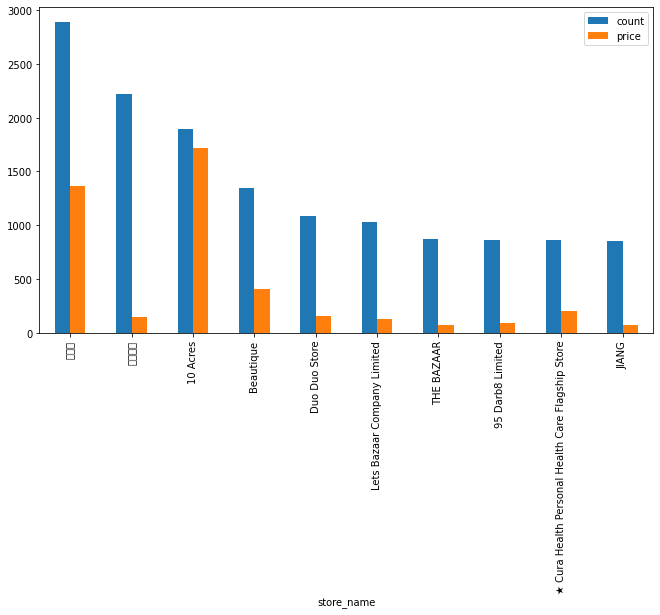

In [150]:
brandcount = hktvmalldf[['store_name','name']].groupby(by=['store_name']).count()
brandpricemean = hktvmalldf[['store_name','price']].groupby(by=['store_name']).mean()

pricecount = pd.merge(brandcount, brandpricemean, on='store_name')
pricecountsort = pricecount.sort_values(by='name', ascending=False)[:10]

pricecountsort.rename(columns={'name':'count'}, inplace=True)
pricecountsort.plot.bar(figsize=(11, 6), rot=90)

## ParkNShop

### Top 10 brand by number of products

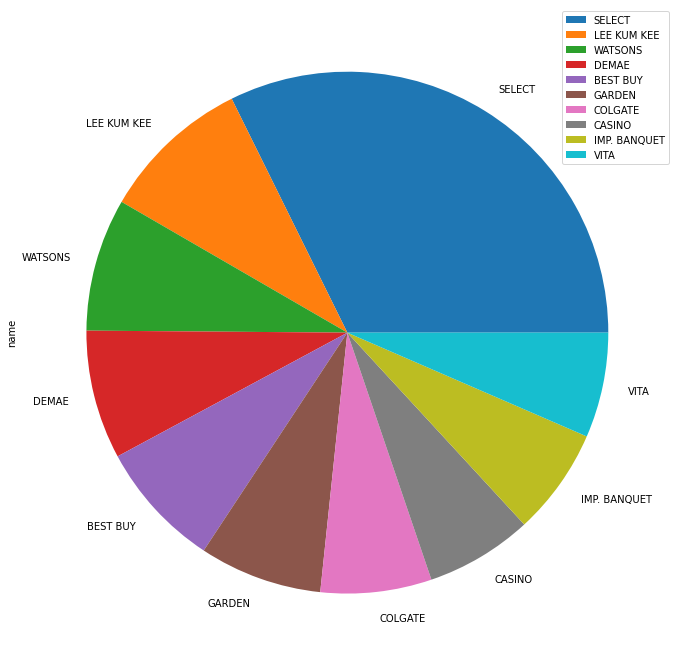

In [159]:
pnkdf.groupby(by=['brand']).count().sort_values(by=['name'], ascending=False)[:10].plot.pie(y='name', figsize=(22, 12))

### Top 10 number of products in brand and price average

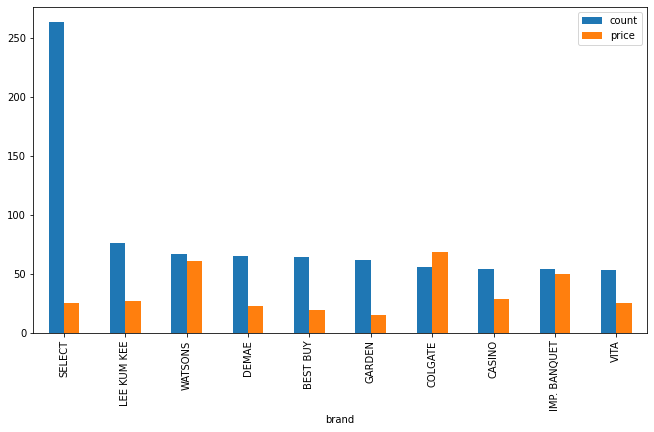

In [160]:
brandcount = pnkdf[['brand','name']].groupby(by=['brand']).count()
brandpricemean = pnkdf[['brand','price']].groupby(by=['brand']).mean()

pricecount = pd.merge(brandcount, brandpricemean, on='brand')
pricecountsort = pricecount.sort_values(by='name', ascending=False)[:10]

pricecountsort.rename(columns={'name':'count'}, inplace=True)
pricecountsort.plot.bar(figsize=(11, 6), rot=90)

## Execrise

Please plot a **pie chart** to the top 10 `Origin` with most products in `pnkdf`.

Please plot a **bar chart** to show **product count** and **price average** of the top 10 `Origin` in `pnkdf`.

# Interactive visualization

In [ ]:
!pip install altair vega_datasets


https://altair-viz.github.io

![](https://url2img-web.herokuapp.com/aHR0cHM6Ly9hbHRhaXItdml6LmdpdGh1Yi5pby8=)


https://altair-viz.github.io/gallery/index.html#interactive-charts
![](https://url2img-web.herokuapp.com/aHR0cHM6Ly9hbHRhaXItdml6LmdpdGh1Yi5pby9nYWxsZXJ5L2luZGV4Lmh0bWwjaW50ZXJhY3RpdmUtY2hhcnRz)

## Examples

### ParkNShop brand product count

In [178]:
brandcount = pnkdf[['brand','name']].groupby(by=['brand'], as_index=False).count().sort_values(by=['name'])

In [183]:
alt.Chart(brandcount[:30]).mark_bar().encode(
    x='brand',
    y='name',
)

alt.Chart(...)

### Interactive average selection

In [184]:
import altair as alt
from vega_datasets import data

source = data.seattle_weather()
brush = alt.selection(type='interval', encodings=['x'])

bars = alt.Chart().mark_bar().encode(
    x='brand',
    y='mean(name):Q',
    opacity=alt.condition(brush, alt.OpacityValue(1), alt.OpacityValue(0.7)),
).add_selection(
    brush
)

line = alt.Chart().mark_rule(color='firebrick').encode(
    y='mean(name):Q',
    size=alt.SizeValue(3)
).transform_filter(
    brush
)

alt.layer(bars, line, data=brandcount[:30])


alt.LayerChart(...)